In [85]:
# To write a Python 2/3 compatible codebase, the first step is to add this line to the top of each module
from __future__ import division, print_function, unicode_literals
# The simplest possible classifier is the nearest neighbor: given a new observation X_test, find in the training set 
#(i.e. the data used to train the estimator) the observation(s) with the closest feature vector.
# This script illustrates the usage of kNN. 

# Import necessary libraries and specify that graphs should be plotted inline.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn import linear_model  
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve, auc
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
import catboost
from catboost import Pool, CatBoostClassifier
import pprint
from time import time
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
import datetime
import itertools
from sklearn import svm


# Helper Function for Normalized Confusion Matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Perfomance reporter for cat boost    
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params    
    

np.random.seed(42) # Ensure reproducability
############################################################################################################

# Load Data
df = pd.read_csv("cleaned_data.csv")
df.shape
df.columns
df.dtypes

# Change PatientId and AppointmentID to string 
df['PatientId'] = df.PatientId.astype(str)
df['AppointmentID'] = df.AppointmentID.astype(str)

# Set Up Data for Models

## Declare Attributes and Split Data

In [131]:
# Declare Attributes 
X = df.iloc[:, 0:55]   # Specify attributes
y = df.iloc[:, 55]  # specify target column LAST_NYC
columns = X.columns

In [27]:
############################################    Split the Data   ############################################
# Split validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print(y_train.count())
print(y_test.count())

50283
21551


## Normalize Values

In [28]:
# Remove IDs so that they do not get normalized, and attach back
X_train_IDS = X_train[['PatientId', 'AppointmentID']]
X_test_IDS = X_test[['PatientId', 'AppointmentID']]

X_train = X_train.drop(['PatientId', 'AppointmentID'], axis=1)
X_test = X_test.drop(['PatientId', 'AppointmentID'], axis=1)

# Normalizing continuous variables
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Learning Curve

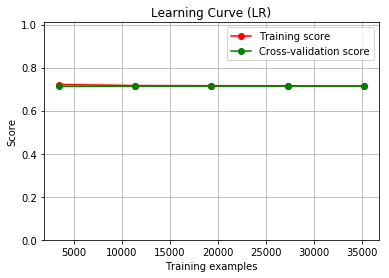

In [29]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curve (LR)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X_train, y_train, (0.0, 1.01), cv=cv, n_jobs=4)
plt.show()

## Rebalance Training Datasets

In [13]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)
print(y_train_balanced.value_counts())

1    35944
0    35944
Name: No-show, dtype: int64


# Decision Tree

## Optimizing Parameters

In [77]:
# Find optimal paramater for DecisionTreeClassifier with GridSearchCV
inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)

# Inner CV
parameters = {'max_depth':range(3,50), 'min_samples_split': range(2,50)}      # range of parameters for the depth of the tree
gs_dt = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4, scoring = 'f1_micro') #GridSearchCV
gs_dt.fit(X_train_balanced, y_train_balanced) # Fit model

gs_dt = gs_dt.fit(X_train_balanced,y_train_balanced)
print(" Parameter Tuning")
print("Non-nested Performance: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)    # Parameter setting that gave the best results on the hold out data.
print("Optimal Estimator: ", gs_dt.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score

 Parameter Tuning
Non-nested Performance:  0.811123545664915
Optimal Parameter:  {'max_depth': 46, 'min_samples_split': 2}
Optimal Estimator:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=46, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


## Fit Optimized Model

In [206]:
#################################### Train the Decision Tree Model ####################################
# Decision Tree Classifier
tree_basic = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=46, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
tree_basic.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=46, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

## Evaluating Optimized Model

0    15406
1     6145
Name: No-show, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.73      0.73     15406
           1       0.34      0.36      0.35      6145

    accuracy                           0.62     21551
   macro avg       0.54      0.54      0.54     21551
weighted avg       0.63      0.62      0.62     21551



Text(0.5, 257.44, 'Predicted label')

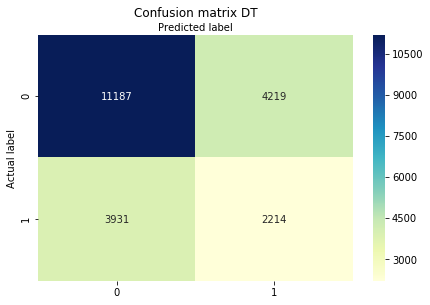

In [209]:
#################################### Apply the Decision Tree Model ####################################
y_pred = tree_basic.predict(X_test)             # Classification prediction

################################### Evaluate the Logistic Regression Model ##################################
print(y_test.value_counts())
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix DT', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.726 0.274]
 [0.64  0.36 ]]


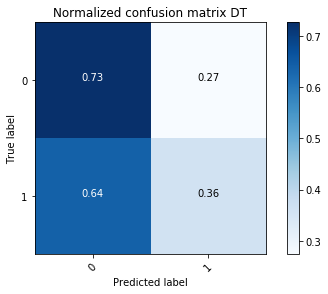

<Figure size 432x288 with 0 Axes>

In [210]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix DT')
plt.figure()
plt.show()

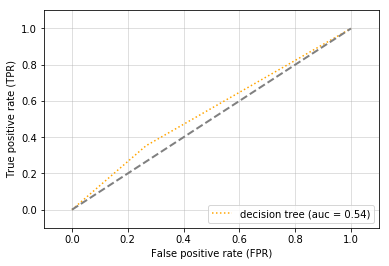

In [86]:
# Assuming the label of the positive class is 1 and data is normalized
y_pred = tree_basic.fit(X_train_balanced,y_train_balanced).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
        color="orange",
        linestyle=":",
        label='%s (auc = %0.2f)' % ("decision tree", roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

# Logistic Regression

## Optimizing Parameters

In [88]:
# Create logistic regression
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0, scoring='f1_micro')

# Fit grid search
best_model = clf.fit(X_train_balanced, y_train_balanced)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 10000.0


## Fit Optimized Model

In [215]:
#################################### Train the Logistic Regression Model ####################################
clf = linear_model.LogisticRegression(C=10000.0, penalty='l2') 

clf = clf.fit(X_train_balanced, y_train_balanced)
print('The weights of the attributes are:', clf.coef_)

y_pred = clf.predict(X_test)             # Classification prediction
y_pred_prob = clf.predict_proba(X_test)  # Class probabilities

The weights of the attributes are: [[-1.013  0.198 -0.141  0.044  0.357 -0.01  -0.161  1.706  1.882 -0.29
  -0.29  -0.41  -0.415 -0.318 -0.474  0.     4.434 -0.045  0.013  0.034
   0.025 -0.052  0.065 -0.037 -0.059  0.023 -0.051 -0.077 -0.133 -0.043
  -0.073 -0.089 -0.078  0.071 -0.173 -0.131 -0.098 -0.091 -0.152 -0.079
  -0.052 -0.072 -0.037 -0.1   -0.08   0.04  -0.011 -0.011 -0.146 -0.045
   0.048  0.023 -0.095]]


## Evaluate Optimized Model

              precision    recall  f1-score   support

           0       0.77      0.56      0.65     15406
           1       0.34      0.57      0.43      6145

    accuracy                           0.57     21551
   macro avg       0.56      0.57      0.54     21551
weighted avg       0.65      0.57      0.59     21551



Text(0.5, 257.44, 'Predicted label')

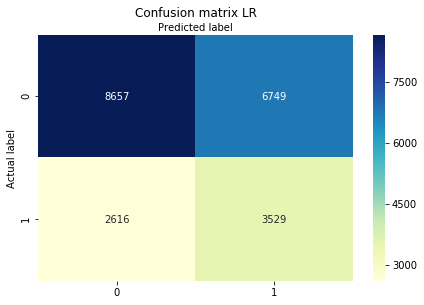

In [216]:
################################### Evaluate the Logistic Regression Model ##################################
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix LR', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Normalized confusion matrix
[[0.562 0.438]
 [0.426 0.574]]


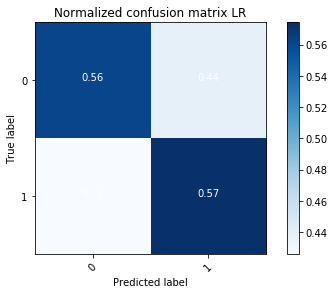

<Figure size 432x288 with 0 Axes>

In [217]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix LR')
plt.figure()
plt.show()

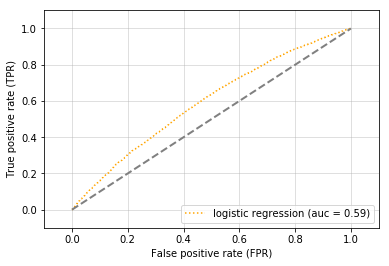

In [218]:
# Assuming the label of the positive class is 1 and data is normalized
y_pred = clf.fit(X_train_balanced,y_train_balanced).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
        color="orange",
        linestyle=":",
        label='%s (auc = %0.2f)' % ("logistic regression", roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

## Find Optimal Cutoff

In [102]:
#################################### Apply the Logistic Regression Model ####################################
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

th = [0.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]

for i in th:
    THRESHOLD = i 
    print('Threshold: ' + str(i))
    y_pred = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    stats = pd.DataFrame(data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
                       precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)], 
                 index=["accuracy", "recall", "precision", "roc_auc_score"])
    print(stats)
    print('')

Threshold: 0.05
                      0
accuracy       0.285138
recall         1.000000
precision      0.285138
roc_auc_score  0.500000

Threshold: 0.1
                      0
accuracy       0.285138
recall         1.000000
precision      0.285138
roc_auc_score  0.500000

Threshold: 0.15
                      0
accuracy       0.285138
recall         1.000000
precision      0.285138
roc_auc_score  0.500000

Threshold: 0.2
                      0
accuracy       0.285277
recall         1.000000
precision      0.285177
roc_auc_score  0.500097

Threshold: 0.25
                      0
accuracy       0.285509
recall         1.000000
precision      0.285243
roc_auc_score  0.500260

Threshold: 0.3
                      0
accuracy       0.288850
recall         0.999024
precision      0.286080
roc_auc_score  0.502303

Threshold: 0.35
                      0
accuracy       0.310937
recall         0.977380
precision      0.289907
roc_auc_score  0.511246

Threshold: 0.4
                      0
accur

# kNN

## Optmizing Parameters

In [104]:
inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)

params = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], 'p':[1,2], 'weights':['uniform','distance']}

knn_regressor = neighbors.KNeighborsClassifier()

gs_dt = GridSearchCV(knn_regressor, params, cv=10) #GridSearchCV
gs_dt.fit(X_train_balanced, y_train_balanced) # Fit model

gs_dt = gs_dt.fit(X_train_balanced,y_train_balanced)
print(" Parameter Tuning")
print("Non-nested Performance: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)    # Parameter setting that gave the best results on the hold out data.
print("Optimal Estimator: ", gs_dt.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score

 Parameter Tuning
Non-nested Performance:  0.7903412535985812
Optimal Parameter:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Optimal Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')


## Fit Optimized Model

In [30]:
#################################### Train the kNN Model ####################################
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
#3NN regressor
knnr= neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')

#Fit and Evaluate Model
knnr.fit(X_train, y_train)  #fit the model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')

## Evaluate Optimized Model

0    15406
1     6145
Name: No-show, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.79      0.76     15406
           1       0.36      0.30      0.33      6145

    accuracy                           0.65     21551
   macro avg       0.55      0.54      0.55     21551
weighted avg       0.63      0.65      0.64     21551



Text(0.5, 257.44, 'Predicted label')

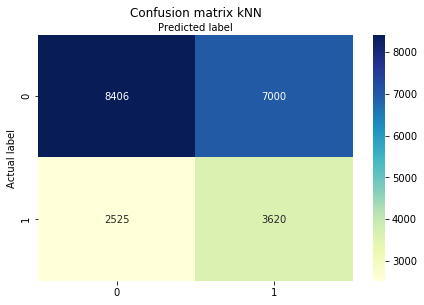

In [31]:
#################################### Apply the kNN Model ####################################
y_pred=knnr.predict(X_test) #make prediction on test set          

################################### Evaluate the kNN Model ##################################
print(y_test.value_counts())
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix kNN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.54563157 0.45436843]
 [0.41090317 0.58909683]]


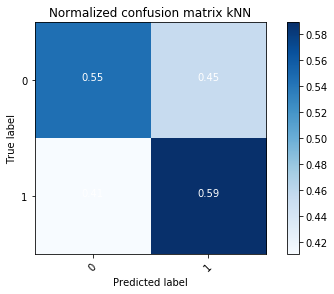

<Figure size 432x288 with 0 Axes>

In [32]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix kNN')
plt.figure()
plt.show()

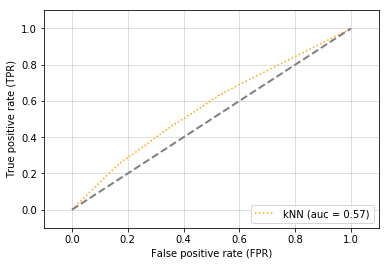

In [224]:
# Assuming the label of the positive class is 1 and data is normalized
y_pred = knnr.fit(X_train_balanced,y_train_balanced).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
        color="orange",
        linestyle=":",
        label='%s (auc = %0.2f)' % ("kNN", roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

# SVM

## Optimizing Parameters

In [17]:
sv = svm.SVC(kernel='linear')
clf = sv.fit(X_train_balanced,y_train_balanced)

## Fit Optimized Model

In [18]:
#################################### Apply the SVM Model ####################################  
y_pred = clf.predict(X_test)

## Evaluate Optimized Model

0    15406
1     6145
Name: No-show, dtype: int64
              precision    recall  f1-score   support

           0       0.77      0.55      0.64     15406
           1       0.34      0.59      0.43      6145

    accuracy                           0.56     21551
   macro avg       0.55      0.57      0.54     21551
weighted avg       0.65      0.56      0.58     21551



Text(0.5, 257.44, 'Predicted label')

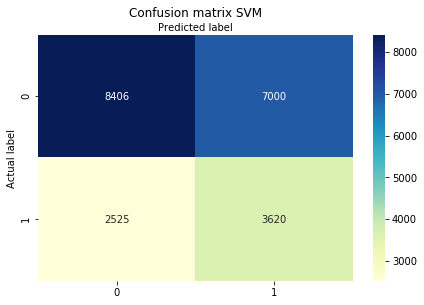

In [21]:
################################### Evaluate the SVM Model ##################################
print(y_test.value_counts())
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix SVM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.54563157 0.45436843]
 [0.41090317 0.58909683]]


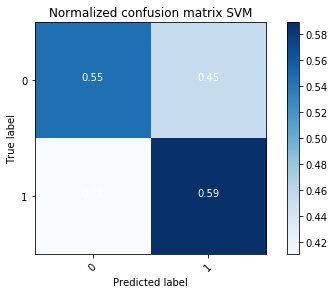

<Figure size 432x288 with 0 Axes>

In [22]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix SVM')
plt.figure()
plt.show()

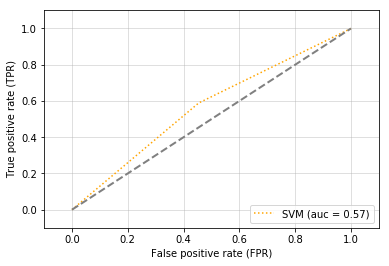

In [24]:
# Assuming the label of the positive class is 1 and data is normalized
fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
        color="orange",
        linestyle=":",
        label='%s (auc = %0.2f)' % ("SVM", roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

# CatBoost

## Reset Data

In [55]:
### Reload data because we do not need to normalize or rebalance
data = pd.read_csv('cleaned_data.csv')
data.drop(['PatientId', 'AppointmentID'], axis = 1, inplace = True)
X = data.drop(['No-show'], axis = 1)
y = data['No-show']

## Optimize modeling

In [56]:
search_spaces = {'iterations': Integer(10, 500),
                 'depth': Integer(2, 10),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight': [51350/20484]}

In [57]:
# Setting up BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
        
clf = CatBoostClassifier(eval_metric='Accuracy',
#                         loss_function='Logloss',
                        verbose = False,
                        task_type = 'GPU')

opt = BayesSearchCV(clf,
                    search_spaces,
                    cv = 5,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [58]:
best_params = report_perf(opt, X, y,'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 17.1602
Function value obtained: -0.5530
Current minimum: -0.5530
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 22.5329
Function value obtained: -0.5437
Current minimum: -0.5530
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 10.3573
Function value obtained: -0.5447
Current minimum: -0.5530
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 28.0991
Function value obtained: -0.5505
Current minimum: -0.5530
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 23.6762
Function value obt

## Running Optimized Model

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = opt
model =  CatBoostClassifier(iterations=406,
                             learning_rate=0.7537928279623535,
                             depth=10,
                             border_count = 83,
                             bagging_temperature = 0.09363393521948817,
                             l2_leaf_reg = 14,
                             scale_pos_weight= 2.5068346026166766,
                             od_type='Iter',
                             random_strength = 1.123769510517113e-09,
                             od_wait=30)

model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
#                  cat_features=categorical_feature_indices,
                 use_best_model=True,
                 plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6708786	test: 0.6806505	best: 0.6806505 (0)	total: 38.7ms	remaining: 15.7s
1:	learn: 0.6633931	test: 0.6788267	best: 0.6788267 (1)	total: 77.2ms	remaining: 15.6s
2:	learn: 0.6596572	test: 0.6798990	best: 0.6788267 (1)	total: 115ms	remaining: 15.5s
3:	learn: 0.6555634	test: 0.6817863	best: 0.6788267 (1)	total: 152ms	remaining: 15.3s
4:	learn: 0.6525770	test: 0.6828617	best: 0.6788267 (1)	total: 194ms	remaining: 15.6s
5:	learn: 0.6495255	test: 0.6833373	best: 0.6788267 (1)	total: 234ms	remaining: 15.6s
6:	learn: 0.6462637	test: 0.6835131	best: 0.6788267 (1)	total: 274ms	remaining: 15.6s
7:	learn: 0.6442530	test: 0.6837041	best: 0.6788267 (1)	total: 307ms	remaining: 15.3s
8:	learn: 0.6407900	test: 0.6849031	best: 0.6788267 (1)	total: 349ms	remaining: 15.4s
9:	learn: 0.6380624	test: 0.6851026	best: 0.6788267 (1)	total: 385ms	remaining: 15.3s
10:	learn: 0.6352463	test: 0.6864544	best: 0.6788267 (1)	total: 425ms	remaining: 15.2s
11:	learn: 0.6335412	test: 0.6866308	best: 0.678826

## Evaluate Optimized Model

0    15386
1     6165
Name: No-show, dtype: int64
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     15386
           1       0.71      0.90      0.79      6165

    accuracy                           0.86     21551
   macro avg       0.83      0.87      0.84     21551
weighted avg       0.88      0.86      0.87     21551



Text(0.5, 257.44, 'Predicted label')

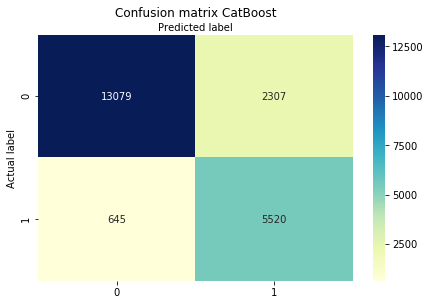

In [76]:
#################################### Apply the CatBoost Model ####################################
clf_pred = opt.predict(X_test)

################################### Evaluate the kNN Model ##################################
print(y_test.value_counts())
# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, clf_pred, target_names=['0', '1']))

cnf_matrix = metrics.confusion_matrix(y_test, clf_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix CatBoost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Normalized confusion matrix
[[0.85005849 0.14994151]
 [0.10462287 0.89537713]]


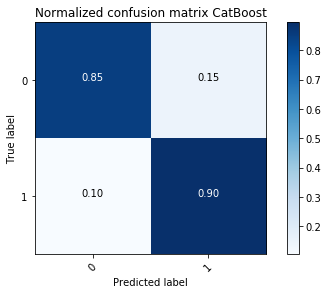

<Figure size 432x288 with 0 Axes>

In [77]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix CatBoost')
plt.figure()
plt.show()

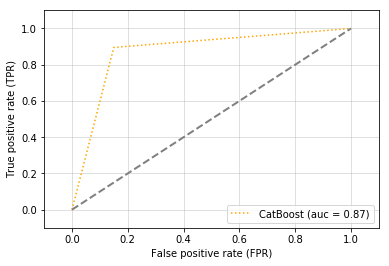

In [78]:
# Assuming the label of the positive class is 1 and data is normalized
y_pred = clf_pred
fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
        color="orange",
        linestyle=":",
        label='%s (auc = %0.2f)' % ("CatBoost", roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

# Output Best Prediction Information from CatBoost

In [135]:
# Reattach predictions to the their original attributes and no-show
test = X.ix[X_test.index]
predictions = pd.DataFrame({"Predicted_No_Show" : clf_pred})
final_csv = pd.concat([test.reset_index(drop=True), y_test.reset_index(drop=True), predictions.reset_index(drop=True)], axis=1)

#Find patients into groups for the reccommender system
conditions = [
    final_csv['SMS_received'].eq(0) & final_csv['Predicted_No_Show'].eq(1), #Predicted No Show AND SMS_received is False
    final_csv['SMS_received'].eq(1) & final_csv['Predicted_No_Show'].eq(0) #Predicted was a Show AND SMS_received is True  
]
final_csv['Patient_Show_Text'] = np.select(conditions, ['NoShow_NoText', 'Show_Text'], default='Neither')

# Output final data/predictions for recommender system
final_csv.to_csv('rec_data.csv', index=False)

In [133]:
final_csv['Patient_Show_Text'].value_counts()

Neither          10518
NoShow_NoText     5617
Show_Text         5416
Name: Patient_Show_Text, dtype: int64

# Feature Importance

In [105]:
opti = CatBoostClassifier(bagging_temperature= 0.9511994100993122,
             border_count=222,
             depth=10,
             iterations=299,
             l2_leaf_reg=4,
             learning_rate=0.9711062441753223,
             random_strength=6.752417731010211,
             scale_pos_weight=2.5068346026166766)

mod = opti.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
#                  cat_features=categorical_feature_indices,
                 use_best_model=True,
                 plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6766893	test: 0.6799563	best: 0.6799563 (0)	total: 71.5ms	remaining: 21.3s
1:	learn: 0.6746019	test: 0.6799091	best: 0.6799091 (1)	total: 114ms	remaining: 16.9s
2:	learn: 0.6728872	test: 0.6797547	best: 0.6797547 (2)	total: 148ms	remaining: 14.6s
3:	learn: 0.6707156	test: 0.6813765	best: 0.6797547 (2)	total: 187ms	remaining: 13.8s
4:	learn: 0.6675335	test: 0.6813185	best: 0.6797547 (2)	total: 226ms	remaining: 13.3s
5:	learn: 0.6662917	test: 0.6822056	best: 0.6797547 (2)	total: 268ms	remaining: 13.1s
6:	learn: 0.6651560	test: 0.6817212	best: 0.6797547 (2)	total: 306ms	remaining: 12.7s
7:	learn: 0.6650311	test: 0.6816570	best: 0.6797547 (2)	total: 316ms	remaining: 11.5s
8:	learn: 0.6634017	test: 0.6835040	best: 0.6797547 (2)	total: 350ms	remaining: 11.3s
9:	learn: 0.6625969	test: 0.6842908	best: 0.6797547 (2)	total: 388ms	remaining: 11.2s
10:	learn: 0.6606806	test: 0.6856868	best: 0.6797547 (2)	total: 433ms	remaining: 11.3s
11:	learn: 0.6588886	test: 0.6872168	best: 0.6797547

100:	learn: 0.4697389	test: 0.8430546	best: 0.6797547 (2)	total: 3.87s	remaining: 7.58s
101:	learn: 0.4681631	test: 0.8448366	best: 0.6797547 (2)	total: 3.9s	remaining: 7.53s
102:	learn: 0.4673687	test: 0.8456844	best: 0.6797547 (2)	total: 3.94s	remaining: 7.49s
103:	learn: 0.4663175	test: 0.8469027	best: 0.6797547 (2)	total: 3.98s	remaining: 7.46s
104:	learn: 0.4647645	test: 0.8496785	best: 0.6797547 (2)	total: 4.02s	remaining: 7.43s
105:	learn: 0.4629284	test: 0.8505207	best: 0.6797547 (2)	total: 4.06s	remaining: 7.39s
106:	learn: 0.4615587	test: 0.8520010	best: 0.6797547 (2)	total: 4.09s	remaining: 7.34s
107:	learn: 0.4589110	test: 0.8562811	best: 0.6797547 (2)	total: 4.12s	remaining: 7.29s
108:	learn: 0.4575127	test: 0.8577733	best: 0.6797547 (2)	total: 4.16s	remaining: 7.24s
109:	learn: 0.4567107	test: 0.8583417	best: 0.6797547 (2)	total: 4.18s	remaining: 7.19s
110:	learn: 0.4549765	test: 0.8608408	best: 0.6797547 (2)	total: 4.22s	remaining: 7.15s
111:	learn: 0.4531540	test: 0.864

199:	learn: 0.3551297	test: 0.9636939	best: 0.6797547 (2)	total: 8.32s	remaining: 4.12s
200:	learn: 0.3543012	test: 0.9634859	best: 0.6797547 (2)	total: 8.36s	remaining: 4.08s
201:	learn: 0.3536370	test: 0.9638654	best: 0.6797547 (2)	total: 8.41s	remaining: 4.04s
202:	learn: 0.3526213	test: 0.9662045	best: 0.6797547 (2)	total: 8.47s	remaining: 4s
203:	learn: 0.3517458	test: 0.9670499	best: 0.6797547 (2)	total: 8.54s	remaining: 3.98s
204:	learn: 0.3505671	test: 0.9684202	best: 0.6797547 (2)	total: 8.59s	remaining: 3.94s
205:	learn: 0.3497231	test: 0.9695456	best: 0.6797547 (2)	total: 8.64s	remaining: 3.9s
206:	learn: 0.3487730	test: 0.9703935	best: 0.6797547 (2)	total: 8.69s	remaining: 3.86s
207:	learn: 0.3475323	test: 0.9719323	best: 0.6797547 (2)	total: 8.86s	remaining: 3.87s
208:	learn: 0.3462560	test: 0.9732760	best: 0.6797547 (2)	total: 8.95s	remaining: 3.85s
209:	learn: 0.3452025	test: 0.9748045	best: 0.6797547 (2)	total: 8.99s	remaining: 3.81s
210:	learn: 0.3441858	test: 0.976364

296:	learn: 0.2762525	test: 1.0672834	best: 0.6797547 (2)	total: 13.1s	remaining: 88.2ms
297:	learn: 0.2754301	test: 1.0680537	best: 0.6797547 (2)	total: 13.1s	remaining: 44.1ms
298:	learn: 0.2748753	test: 1.0679129	best: 0.6797547 (2)	total: 13.2s	remaining: 0us

bestTest = 0.6797547067
bestIteration = 2

Shrink model to first 3 iterations.


In [118]:
train_pool = Pool(X_train, y_train)
feature_importances = mod.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Age: 30.001647494181107
Lead_Time: 24.33405766982406
Neigh_No-show_Percentage: 15.588332549041258
SMS_received: 11.54855260450441
Scholarship: 5.932133889932127
is_Male: 3.379739375038119
Appt_Weds: 3.3304383329378644
Appt_Mon: 2.230127501703981
is_ITARARÉ: 1.2915752457736873
ILHA_DO_PRÍNCIPE: 0.7939348945627451
is_NOVA_PALESTINA: 0.5123768408557376
Appt_Tues: 0.42532642699559764
is_DA_PENHA: 0.4048856572885089
Scheduled_Weekday: 0.2162606615368019
Appt_Sat: 0.010610855823994859
is_TABUAZEIRO: 0.0
is_SÃO_PEDRO: 0.0
is_SÃO_CRISTÓVÃO: 0.0
is_SÃO_BENEDITO: 0.0
is_SÃO JOSÉ: 0.0
is_SANTO_ANTÔNIO: 0.0
is_SANTO_ANDRÉ: 0.0
is_SANTOS_DUMONT: 0.0
is_SANTA_TEREZA: 0.0
is_SANTA_MARTHA: 0.0
is_ROMÃO: 0.0
is_RESISTÊNCIA: 0.0
is_REDENÇÃO: 0.0
is_PRAIA_DO_SUÁ: 0.0
is_MARUÍPE: 0.0
is_MARIA_ORTIZ: 0.0
is_JOANA_D´ARC: 0.0
is_JESUS_DE_NAZARETH: 0.0
is_JARDIM_DA_PENHA: 0.0
is_JARDIM_CAMBURI: 0.0
is_JABOUR: 0.0
is_ILHA_DE_SANTA_MARIA: 0.0
is_GURIGICA: 0.0
is_FORTE_SÃO_JOÃO: 0.0
is_CRUZAMENTO: 0.0
is_CONSOLA

# Recommender System Evaluation

In [150]:
id_score = pd.read_csv("id and score.csv")
no_show = pd.read_csv("rec_data.csv")

Index(['Unnamed: 0', 'AppointmentId', 'Similarity_Score'], dtype='object')

In [151]:
id_score = id_score[['AppointmentId', 'Similarity_Score']]
id_score.columns = 
no_show = no_show[['AppointmentID', 'No-show', 'Predicted_No_Show', 'Patient_Show_Text']]

In [154]:
conditions = [
    no_show['No-show'].eq(1) & no_show['Predicted_No_Show'].eq(1), # TP
    no_show['No-show'].eq(0) & no_show['Predicted_No_Show'].eq(1), # FP
    no_show['No-show'].eq(1) & no_show['Predicted_No_Show'].eq(0) #FN
]

no_show['CFMatrix'] = np.select(conditions, ['TP', 'FP', 'FN'], default='TN')
no_show

,AppointmentID,No-show,Predicted_No_Show,Patient_Show_Text,CFMatrix
0,5712088,0,1,Neither,FP
1,5716486,1,1,Neither,TP
2,5640643,0,1,Neither,FP
3,5763053,0,0,Show_Text,TN
4,5609682,1,0,Show_Text,FN
5,5669997,0,0,Show_Text,TN
6,5578053,1,0,Neither,FN
7,5657670,0,1,NoShow_NoText,FP
8,5691550,0,1,NoShow_NoText,FP
9,5664758,0,1,NoShow_NoText,FP


In [155]:
merge_sim = pd.merge(id_score, no_show, left_on='AppointmentId', right_on='AppointmentID')

In [163]:
merge_sim = merge_sim.drop('AppointmentID', axis=1)

In [174]:
from pandasql import * 

# cutoff= .7
cut7 = sqldf('SELECT Patient_Show_Text, CFMatrix, COUNT(*) FROM merge_sim WHERE Similarity_Score >= .7 GROUP BY Patient_Show_Text, CFMatrix ')
cut7

,Patient_Show_Text,CFMatrix,COUNT(*)
0,Neither,FN,7
1,Neither,TN,23
2,NoShow_NoText,FP,164
3,NoShow_NoText,TP,102


In [172]:
# cutoff= .5
cut7 = sqldf('SELECT Patient_Show_Text, CFMatrix, COUNT(*) FROM merge_sim WHERE Similarity_Score >= .5 GROUP BY Patient_Show_Text, CFMatrix ')
cut7

,Patient_Show_Text,CFMatrix,COUNT(*)
0,Neither,FN,9
1,Neither,TN,27
2,NoShow_NoText,FP,296
3,NoShow_NoText,TP,198


In [171]:
# cutoff= .3
cut3 = sqldf('SELECT Patient_Show_Text, CFMatrix, COUNT(*) FROM merge_sim WHERE Similarity_Score >= .3 GROUP BY Patient_Show_Text, CFMatrix ')
cut3

,Patient_Show_Text,CFMatrix,COUNT(*)
0,Neither,FN,10
1,Neither,TN,31
2,NoShow_NoText,FP,364
3,NoShow_NoText,TP,249
